# How to use pynar?

`pynar` contains a simplified version of the phenological model implemented in [STICS](https://www.quae.com/produit/1809/9782759236794/stics-soil-crop-model?affiliate_code=). It provides a `phenology` module containing all the functions needed to calculate the phenological stage date (as day of year) for a given crop. The functions are the following ones:
- `photoperiod` : Calculate the photoperiod in hours from latitude and day of year for a given altitude angle.
- `reduction_factor_photoperiod_index` : Calculate the reduction factor for photoperiod index.
- `vernalisation_index`: Calculate the vernalisation index.
- `reduction_factor_vernalisation_index` : Calculate the reduction factor for vernalisation index.
- `crop_effective_temperature` : Calculate the crop effective temperature.
- `crop_development_unit` : Calculate the crop development unit.
- `stage_doy` : Calculate the doy of the phenological stage based on the crop development unit (CDU).

`phenological_stage` encompasses all the above functions and calculates the phenological stage date (doy) for the crop parameters provided.

Let's see how to use it.

## Import packages and load data

In [15]:
# import packages
from pathlib import Path

import xarray as xr
from xclim.core.units import convert_units_to
import matplotlib.pyplot as plt

import pynar.phenology as pn

# load the example dataset
DATA_PATH = r'C:\Users\1116_temp1\Documents\DATA'
fp = [f for f in (Path(DATA_PATH) / "EXPLORE2/CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63/rcp85").glob('*tasAdjust*.nc')]
tas = xr.open_dataset(fp[0])

# subset of data
tas = tas.sel(time=slice("2010", "2015"))
tas["tasAdjust"] = convert_units_to(tas["tasAdjust"], "degC")

tas

<xarray.Dataset> Size: 168MB
Dimensions:         (x: 143, y: 134, time: 2191)
Coordinates:
  * x               (x) float64 1kB 6e+04 6.8e+04 ... 1.188e+06 1.196e+06
  * y               (y) float64 1kB 1.617e+06 1.625e+06 ... 2.673e+06 2.681e+06
  * time            (time) datetime64[ns] 18kB 2010-01-01 ... 2015-12-31
    lat             (y, x) float64 153kB ...
    lon             (y, x) float64 153kB ...
Data variables:
    LambertParisII  float32 4B ...
    tasAdjust       (time, y, x) float32 168MB nan nan nan nan ... nan nan nan
Attributes: (12/38)
    description:                    Created by xios
    title:                          Created by xios
    Conventions:                    CF-1.6
    creation_date:                  2018-11-19T14:35:23Z
    name:                           EUR-11_CNRM-CERFACS-CNRM-CM5_rcp85_r1i1p1...
    institute_id:                   CNRM
    ...                             ...
    bc_domain:                      FR-France
    bc_period_ref:                  1980-2011
    bc_period_rcm:                  1974-2005
    bc_info:                        Meteo-France-ADAMONT-France_SAFRAN-France...
    product:                        bias-correction
    bc_comment:                     Weather Regime dependant BC methode

## Phenological Stage Calculation
We can now calculate phenological stages. As example, we use a wheat with an early-intermediate maturity. Its crop parameters required to calculate phenological stages are below:

In [16]:
crop_params = {
    "sensiphot": 0,
    "phobase": 6.3,
    "phosat": 20,
    "optimum_temp": 6.5,
    "thermal_sensi": 10,
    "vern_mindays": 7,
    "vern_ndays": 55,
    "tmin_thresh": 0,
    "tmax_thresh": 28,
    "tstop_thresh": 100
}

### Step by Step
Let's see how to compute the phenological stage step by step.

#### 1. Photoperiod
The photoperiod changes throught the year and depends of the latitudes, so we need to provide the `dates` and `lat` parameters.

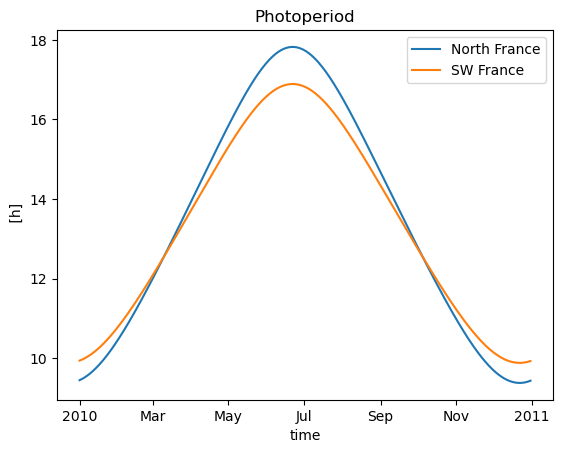

In [17]:
# photoperiod
phoi = pn.photoperiod(dates=tas.time, lat=tas.lat)

# plot photoperiod for two different locations
phoi.isel(x=75, y=115, time=slice(0,365)).plot(label='North France') # North of France
phoi.isel(x=45, y=50, time=slice(0,365)).plot(label='SW France') # South West of France
plt.title("Photoperiod")
plt.legend()
plt.show()

From the photoperiod we can calculate the photoperiod reduction factor. It differs for each crops so we need to provide the following crop parameters: `sensiphot` (photoperiod sensitivity), `phobase` (base photoperiod) and `phosat` (saturation photoperiod).

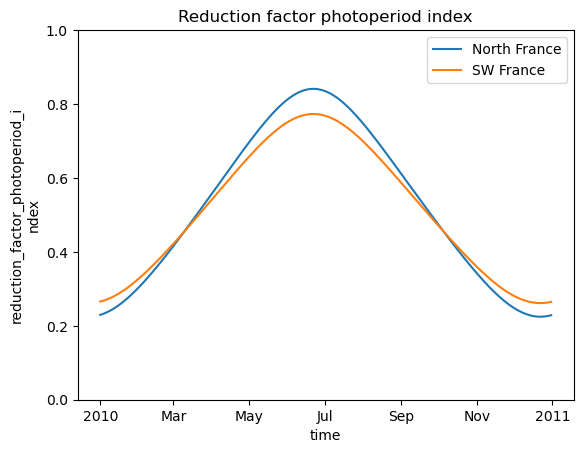

In [18]:
# reduction factor photoperiod index
rfpi = pn.reduction_factor_photoperiod_index(phoi, sensiphot=0, phobase=6.3, phosat=20)

# plot reduction factor photoperiod index for two different locations
rfpi.isel(x=75, y=115, time=slice(0,365)).plot(label='North France') # North of France
rfpi.isel(x=45, y=50, time=slice(0,365)).plot(label='SW France') # South West of France
plt.ylim(0, 1)
plt.title("Reduction factor photoperiod index")
plt.legend()
plt.show()

#### 2. Vernalisation

The vernalisation is also crop dependent a to calculate the vernalisation index, we need the optimum vernalisation temperature (`optimum_temp`) of the crop and its thermal sensivity to vernalisation (`thermal_sensi`).

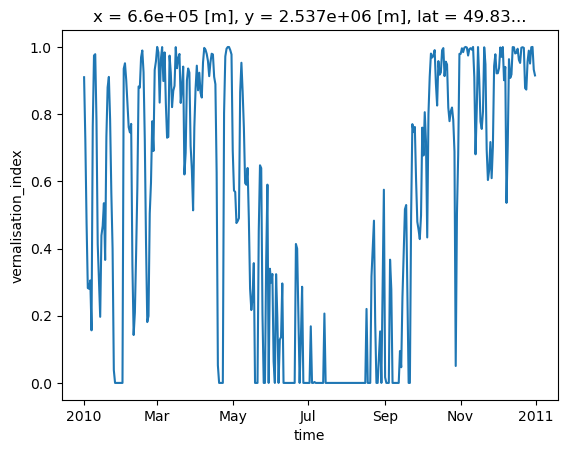

In [19]:
# vernalisation index
vi = pn.vernalisation_index(tas.tasAdjust, optimum_temp=6.5, thermal_sensi=10)

# plot vernalisation index for one location
vi.isel(x=75, y=115, time=slice(0, 365)).plot()
plt.show()

As for photperiod, we can now calculate the vernalisation reduction factor. For this, we need to provide `vern_mindays` (the minimum number of vernalising days before starting the vernalisation process), `vern_ndays` (number of vernalising days to reach vernalisation requirements) and `start_doy` which correspond to the day of year when vernalisation accumulation start (i.e., sowing date).

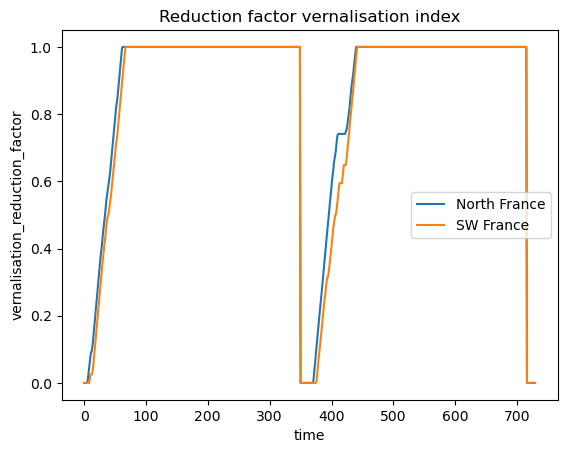

In [20]:
# reduction factor vernalisation index
rfvi = pn.reduction_factor_vernalisation_index(vi, vern_mindays=7, vern_ndays=55, start_doy=288, freq="YS-OCT")

# plot reduction factor vernalisation index two different locations
rfvi.isel(x=75, y=115, time=slice(288, 288+365*2)).plot(label='North France') # North of France
rfvi.isel(x=45, y=50, time=slice(288, 288+365*2)).plot(label='SW France') # South West of France
# time=slice(270, 288+380) to show two cycles
plt.title("Reduction factor vernalisation index")
plt.legend()
plt.show()

The `start_doy` corresponds to the day of year when the vernalisation starts its accumulation and usually corresponds to the sowing date. In our exemple, `start_doy=288` is October 15. `freq` defines the period during the crop cycle extends and should match the month of the start of the growing cycle (`start_doy`), thus `YS-OCT` for October in this example. For a April 15 sowing date (e.g., Sourthern Hemisphere), it will `freq='YS-APR'`.

#### 3. Crop Effective Temperature

The crop effective temperature is calculated from the three threshodl temperature: the threshold temperature below which temperature has no effect on crop development (`tmin_thresh`), the threshold temperature with maximum effect (`tmax_thresh`) and the threshold temperature above which temperature has no effect (`tstop_thresh`).

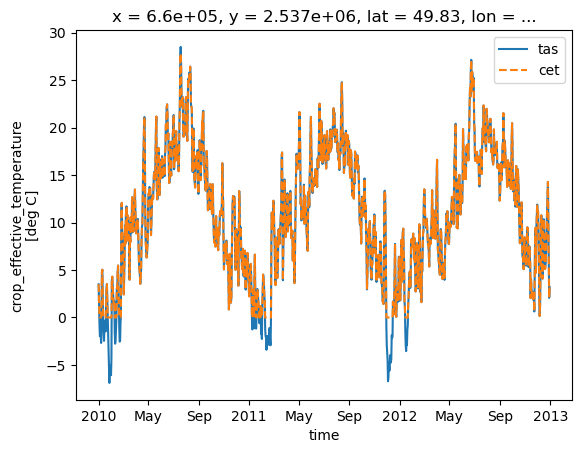

In [21]:
# crop effective temperature
cet = pn.crop_effective_temperature(tas.tasAdjust, tmin_thresh=0, tmax_thresh=28, tstop_thresh=100)

# plot temperature vs cet for a given cell
tas.tasAdjust.isel(x=75, y=115, time=slice(0, 365*3)).plot(label="tas")
cet.isel(x=75, y=115, time=slice(0, 365*3)).plot(label="cet", linestyle="--")
plt.legend()
plt.show()

#### 4. Crop Development Unit (CDU)

The CDU (actually, the cumulative CDU) is the variable that is used to determine the phenological stages and corresponds to the product of the crop development temperature, reduction factor photoperiod index and reduction factor vernalisation index:
$$cdu = cet * rfpi * rfvi$$
Depending of the crop or the phenological stage we are looking at, the _rfpi_ and/or _rfvi_ may not influence the crop developement and won't be considered (i.e., equal to 1 corresponding to no effect). Let's have a look to the difference.

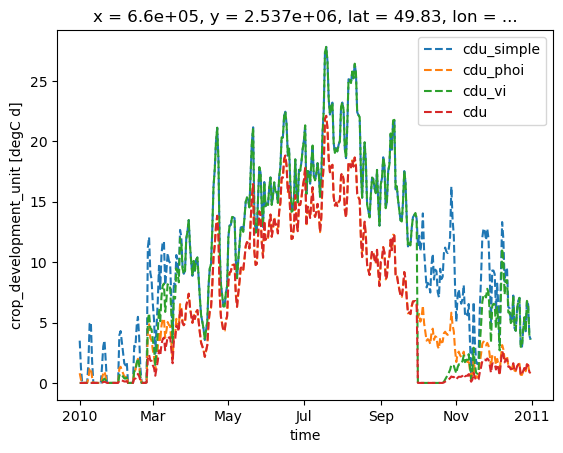

In [22]:
# simple: without photoperiod and vernalisation
cdu_simple = pn.crop_development_unit(crop_temp=cet, rfpi=None, rfvi=None)
# with photoperiod
cdu_phoi = pn.crop_development_unit(crop_temp=cet, rfpi=rfpi, rfvi=None)
# with vernalisation
cdu_vi = pn.crop_development_unit(crop_temp=cet, rfpi=None, rfvi=rfvi)
# with photoperiod and vernalisation
cdu = pn.crop_development_unit(crop_temp=cet, rfpi=rfpi, rfvi=rfvi)

# plot the results for a given cell for one year
cdu_simple.isel(x=75, y=115, time=slice(0, 365)).plot(label="cdu_simple", linestyle="--")
cdu_phoi.isel(x=75, y=115, time=slice(0, 365)).plot(label="cdu_phoi", linestyle="--")
cdu_vi.isel(x=75, y=115, time=slice(0, 365)).plot(label="cdu_vi", linestyle="--")
cdu.isel(x=75, y=115, time=slice(0, 365)).plot(label="cdu", linestyle="--")
plt.legend()
plt.show()

#### 5. Stage Day of Year

We use `stage_doy` to calculate the date (day of year) at which the stage occurs. The function needs several parameters: `cdu`  that is the relevant crop development unit (i.e., with or without photoperiod and/or vernalisation considered), threshold of CDU required to reach the phenological stage, the day of year corresponding to the start of the growing 
We are going to use as example the CDU calculated with both, vernalisation and photoperiod. The `from_doy` parameter is used to defined from which day of year, the CDU accumulation start and corresponds to the date of the previous stage. Here as we calculate the first phenological stage, it corresponds to the sowing date. `freq` should match the frequency used for the calculated of the vernalisation reduction factor.

For the first stage we use the CDU considering only the photoperiod (`cdu_phoi`).

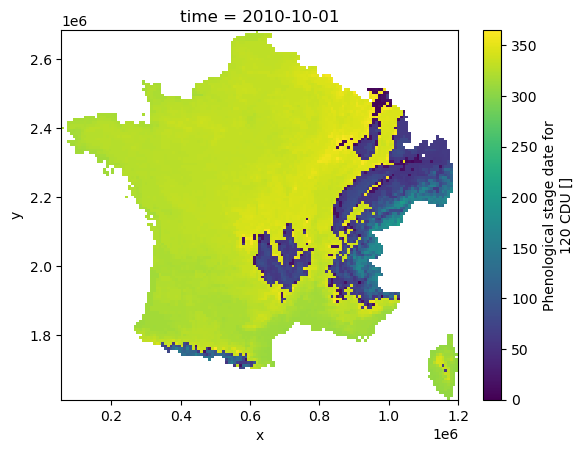

In [23]:
# first stage: need 120 CDU from sowing date
s1 = pn.stage_doy(
    cdu=cdu_phoi,
    thresh=120,
    from_doy=288,  # date of previous stage
    freq="YS-OCT"  # yearly frequency starting in October
)

# plot the first stage for the first year
s1.isel(time=1).plot(vmin=0, vmax=365, cmap="viridis")
plt.show()

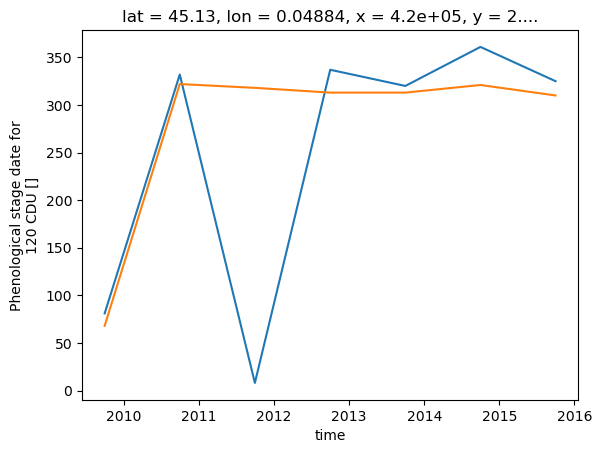

In [24]:
# plot the first stage date for two different locations
s1.isel(x=75, y=115).plot(label='North France') # North of France
s1.isel(x=45, y=50).plot(label='SW France') # South West of France
plt.show()

Because the occurrance of the first stage is close to the end of the year, cells that need more time to reach threshold have a date occuring the next year and thus have low day of year compared to other cells, making interpretation difficult. We can convert the day of year to day since the beginning of the season (i.e., since the first day of the `freq` used, here October 1st) using xclim's `doy_to_days_since` function.

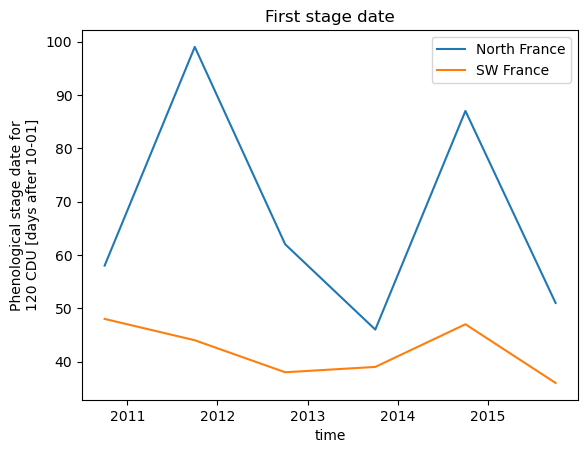

In [25]:
from xclim.core.calendar import doy_to_days_since

s1_since = doy_to_days_since(s1)
# plot the result
# plot the first stage date for two different locations
s1_since.isel(x=75, y=115, time=slice(1,7)).plot(label='North France') # North of France
s1_since.isel(x=45, y=50, time=slice(1,7)).plot(label='SW France') # South West of France
# we remove the first year because it is not complete
plt.title("First stage date")
plt.legend()
plt.show()

We can now calculate at wich date the second stage occurs. For this, 210 CDU are required from the first stage and we use the CDU calculated considering photoperiod and vernailisation (`cdu`).

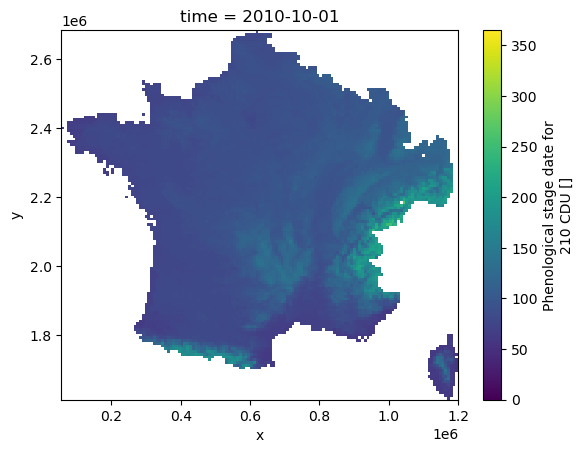

In [26]:
s2 = pn.stage_doy(
    cdu=cdu,
    thresh=210,
    from_doy=s1, # previous stage
    freq="YS-OCT"  # yearly frequency starting in October
)

# plot the second stage for the first year
s2.isel(time=1).plot(vmin=0, vmax=365, cmap="viridis")
plt.show()

We can see that two cells on the East of France now as NaN value. This means that at the end of the year (September 30 y+1), the CDU accumulation isn't enough to meet the stage requirements.

### Direct Approach

While this workflow works, we implemented it in the `phenological_stage` to ease its use. Let's recalculate the first stage date with this one and compare results.

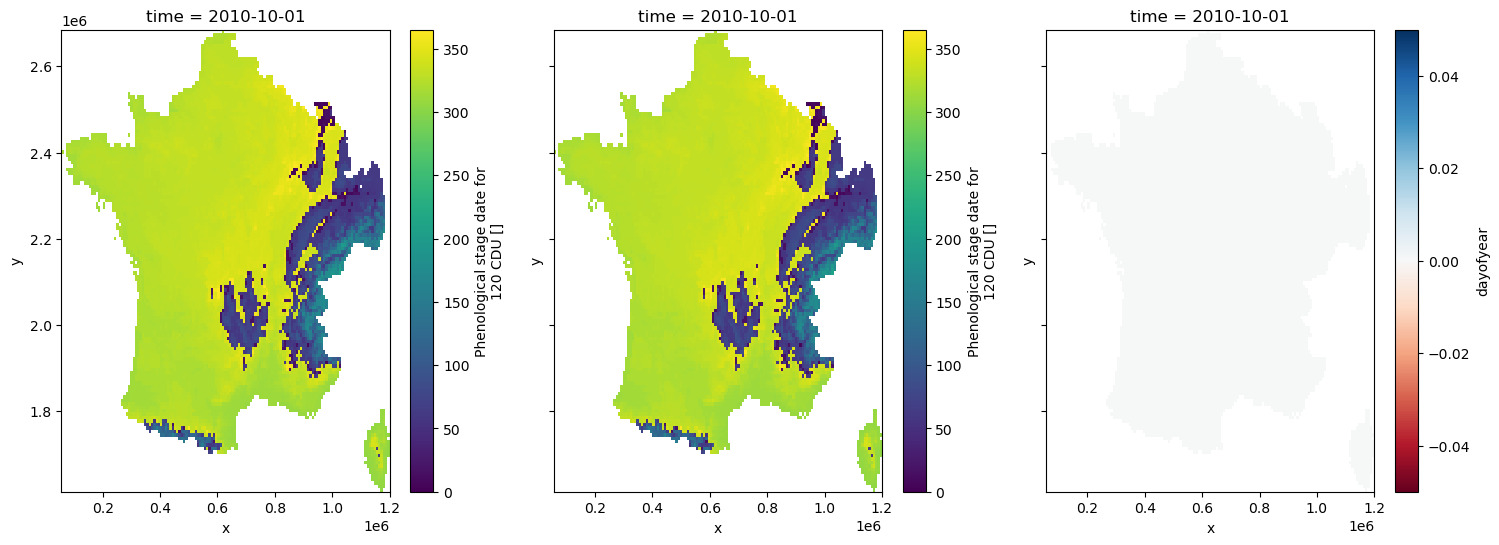

In [27]:
s1_bis = pn.phenological_stage(
    tas=tas.tasAdjust,
    thresh=120,
    params=crop_params, # all parameters to use
    is_photoperiod=True,  # use photoperiod
    is_vernalisation=False,  # do not use vernalisation
    start_cycle_doy=288,  # sowing date
    freq="YS-OCT"
)

delta = s1 - s1_bis

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)
s1.isel(time=1).plot(vmin=0, vmax=365, cmap="viridis", ax=ax[0])
s1_bis.isel(time=1).plot(vmin=0, vmax=365, cmap="viridis", ax=ax[1])
delta.isel(time=1).plot(cmap="RdBu", ax=ax[2])
plt.show()

Both approaches lead to the same results.

In the same way, we can calculate the second and third stages dates.

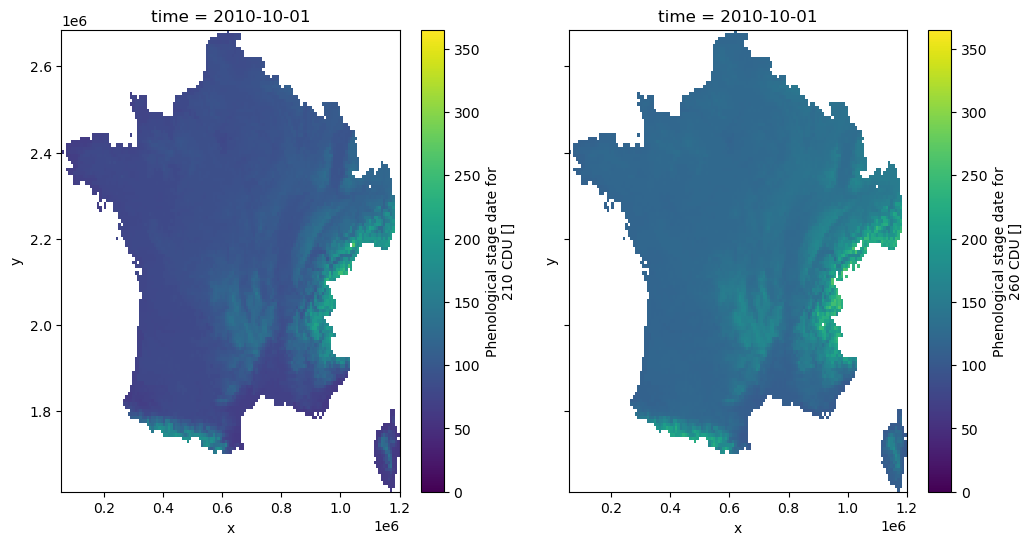

In [28]:
s2_bis = pn.phenological_stage(
    tas=tas.tasAdjust,
    thresh=210,
    params=crop_params, # all parameters to use
    is_photoperiod=True,  # use photoperiod
    is_vernalisation=True,  # use vernalisation
    start_cycle_doy=288,  # sowing date
    from_doy=s1_bis,  # previous stage
    freq="YS-OCT"
)

s3 = pn.phenological_stage(
    tas=tas.tasAdjust,
    thresh=260,
    params=crop_params, # all parameters to use
    is_photoperiod=True,  # use photoperiod
    is_vernalisation=True,  # use vernalisation
    start_cycle_doy=288,  # sowing date
    from_doy=s2_bis,  # previous stage
    freq="YS-OCT"
)

# plot the second and third stages
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
s2.isel(time=1).plot(vmin=0, vmax=365, cmap="viridis", ax=ax[0])
s3.isel(time=1).plot(vmin=0, vmax=365, cmap="viridis", ax=ax[1])
plt.show()